In [1]:
import gym
import gym.spaces
from gym.utils import seeding
from gym.envs.registration import EnvSpec
import enum
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import sklearn
import tensorflow as tf
from tensorflow import keras
np.random.seed(42)
tf.random.set_seed(42)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

In [2]:
from gym import Env
from gym.spaces import Discrete, Box
import random
from scipy.stats import boxcox
from fracdiff.sklearn import FracdiffStat
#frac = FracdiffStat()
from collections import deque
import tensorflow_probability as tfp
import time

In [3]:
class Actions(enum.Enum):
    Long = 0
    Short = 1

In [4]:
def WMA(data, period=20):
    wma = []
    divisor = (period*(period+1))/2
    for i in range(len(data)):
        div = divisor
        num = 0
        for a in range(period):
            if (i-a) >= 0:
                num += data[i-a] * (period - a)
            elif (i-a) < 0:
                div -= period - a
        num = num/div
        wma.append(num)
    return np.array(wma)

In [5]:
def hull_ma(data, period=20):
    half = round(period/2)
    wma1 = WMA(data, half)
    wma2 = WMA(data, period)
    raw_wma = (2*wma1) - wma2
    sqrt = round(period ** 0.5)
    hma = WMA(raw_wma, sqrt)
    return hma

In [6]:
def sharpe(ls):
    return np.mean(ls)/np.std(ls)

In [7]:
DEFAULT_BARS_COUNT = 63
DEFAULT_COMMISSION_PERC = 0.0025
BETA_START = 0.4
BETA_EPISODES = 500

In [8]:
class SGA_Env(Env):
    metadata = {'render.modes': ['human']}
    spec = EnvSpec('StocksEnv-v0') #not quite sure what this does, but 
    #i might change the name
    
    def __init__(self, prices, bars_count=DEFAULT_BARS_COUNT,
                commission_perc=DEFAULT_COMMISSION_PERC, state_1d=True,
                random_ofs_on_reset=True, reward_on_close=True, noise_on=True):
        
        #assert isinstance(prices, dict)
        self._prices = prices
        
        bars_count = int(bars_count)
        self.bars_count = bars_count
        self.noise_on = noise_on
        
        if state_1d:
            self._state = State1D(prices,
                bars_count=DEFAULT_BARS_COUNT, commission_perc=DEFAULT_COMMISSION_PERC,
                reward_on_close=reward_on_close, noise_on=self.noise_on)
        else:
            self._state = State(prices,
                bars_count=DEFAULT_BARS_COUNT, commission_perc=DEFAULT_COMMISSION_PERC,
                reward_on_close=reward_on_close)
            
        #Actions
        self.action_space = Discrete(n=len(Actions))
        #Observation array    
        self.observation_space = Box(low=-np.inf, high=np.inf,
                                    shape=self._state.shape, 
                                     dtype=np.float32)
        
        self.random_ofs_on_reset = random_ofs_on_reset
        self.seed()
        
    def step(self, action, pass_on):
        reward, close_reward, done = self._state.step(action, pass_on)
        obs = self._state.encode()
        info = {
            #figure out what to do for info
            'offset': self._state._offset
        }
        return obs, reward, done, info, close_reward
        
    def reset(self):
        prices = self._prices
        bars = self._state.bars_count
        noise_on = self.noise_on
        if self.random_ofs_on_reset:
            offset = np.random.choice(
                prices.close.shape[0]-bars*5) + bars
        else:
            offset = bars
        self._state.reset(prices, offset)
        return self._state.encode()
    
    '''def render(self, mode='human', close=False):
        pass
    
    def close(self):
        pass
    
    def seed(self, seed=None):
        self.n_random, seed1 = seeding.np_random(seed)
        seed2 = seeding.hash_seed(seed1 + 1) % 2 ** 31
        return [seed1, seed2]
    
    @classmethod
    def from_dir(cls, data_dir, **kwargs):
        prices = {
            file: data.load_relative(file)
            for file in data.price_files(data_dir)
        }
        return EAM_Env(prices, **kwargs)'''

In [3]:
DATA_STORE = 'my_model_data.h5'

In [10]:
class State:
    def __init__(self, prices, bars_count, commission_perc,
                 reward_on_close=True, noise_on=True):
        assert isinstance(bars_count, int)
        assert bars_count > 0
        assert isinstance(commission_perc, float)
        assert commission_perc >= 0.0
        assert isinstance(reward_on_close, bool)
        self.bars_count = bars_count
        self.commission_perc = commission_perc
        self.reward_on_close = reward_on_close
        self.noise_on = noise_on
        
        
    def reset(self, prices, offset):
        assert isinstance(prices, pd.DataFrame)
        assert offset >= self.bars_count-1
        self.position = False
        self.position_buyin_value = 0
        self._prices = prices
        self._offset = offset
        self.reward_cumsum = 0
        self.last_action = -1
        self.noise = 0
        self.dsr = 0
        self.a = 0
        self.b = 0
        
    @property
    def shape(self):
        # [c, h, l, o, ...] * bars + position_flag + rel_profit
        return 20 * self.bars_count
    
    def encode(self):
        #Convert current state into numpy array.
        
        res = np.ndarray(shape=self.shape, dtype=np.float32)
        shift = 0
        #start_index_value = -self.bars_count + 1 + self._offset
        for bar_idx in range(-self.bars_count+1, 1):
            ofs = self._offset + bar_idx
            res[shift] = self._prices.close[ofs] #/self._prices.close[start_index_value]
            shift += 1
            res[shift] = self._prices.high[ofs] #/self._prices.high[start_index_value]
            shift += 1
            res[shift] = self._prices.low[ofs] #/self._prices.low[start_index_value]
            shift += 1
            res[shift] = self._prices.open[ofs] #/self._prices.open[start_index_value]
            shift += 1
            res[shift] = self._prices.volume[ofs] #/self._prices.volume[start_index_value]
            shift += 1
            res[shift] = self._prices.OPM[ofs] #/self._prices.OPM[start_index_value]
            shift += 1
            res[shift] = self._prices.NPM[ofs] #/self._prices.NPM[start_index_value]
            shift += 1
            res[shift] = self._prices.ROA[ofs] #/self._prices.ROA[start_index_value]
            shift += 1
            res[shift] = self._prices.ROE[ofs] #/self._prices.ROE[start_index_value]
            shift += 1
            res[shift] = self._prices.cur_ratio[ofs] #/self._prices.cur_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.quick_ratio[ofs] #/self._prices.quick_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.cash_ratio[ofs] #/self._prices.cash_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.inv_turnover[ofs] #/self._prices.inv_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.acc_rec_turnover[ofs] #/self._prices.acc_rec_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.acc_pay_turnover[ofs] #/self._prices.acc_pay_turnover[start_index_value]
            shift += 1
            res[shift] = self._prices.debt_ratio[ofs] #/self._prices.debt_ratio[start_index_value]
            shift += 1
            res[shift] = self._prices.debt_to_equity[ofs] #/self._prices.debt_to_equity[start_index_value]
            shift += 1
            res[shift] = self._prices.PE[ofs] #/self._prices.PE[start_index_value]
            shift += 1
            res[shift] = self._prices.PB[ofs] #/self._prices.PB[start_index_value]
            shift += 1
            res[shift] = self._prices.Div_yield[ofs] #/self._prices.Div_yield[start_index_value]
            shift += 1
        res[shift] = self.position
        shift += 1
        res[shift] = self.asset_undermanagement_percent() #self.asset_undermanagement_percent()
        return res
    
    def _cur_close(self):
        #Calculate the current close price
        return self._prices.close[self._offset]
    
    '''def percent_gained(self):
        #calculate the percentage of profit the bot would stand to realize if the asset was liquidated
        if (self.position > 0) & (self.position_buyin_tot_value > 0):
            return ((self.position * self._cur_close()) / self.position_buyin_tot_value) - self.commission_perc - 1
        else:
            return 0.0'''
    
    def reward_calculate(self, reward, pass_on, n=0.1):
        a = n*reward + (1-n)*self.a
        b = n*(reward**2) + (1-n)*self.b
        delta_a = reward - self.a
        delta_b = reward**2 - self.b
        
        dt = ((b*delta_a) - (0.5*a*delta_b))/((b-(a**2))**1.5)
        dsr = n*dt
        if pass_on:
            self.dsr += dsr
            self.a = a
            self.b = b
        dsr += self.dsr

        return dsr
        
    def step(self, action, pass_on):
        #Perform a step in the price, adjust offset, check for the end of epoch, 
        # and handle position change
        # :param action:
        # :return: reward, done
        
        #assert isinstance(action, int)
        reward = 0.0
        close_reward=1
        #print(reward)
        done = False
        close = self._cur_close() + self.noise
        if not self.position:
            self.position_buyin_value = close
            self.position = True
        
        if self.last_action != action:
            if self.last_action == 0:
                close_reward = (close/self.position_buyin_value) - self.commission_perc
            elif self.last_action == 1:
                close_reward = 2 - (close/self.position_buyin_value) - self.commission_perc
            self.position_buyin_value = close
            
        self.last_action = action
            
        self._offset += 1
        prev_close = close
        close = self._cur_close()
        
        if self._offset >= self._prices.close.shape[0] - 2:
            done = True
            
        if not pass_on: 
            self._offset -= 1
            
        if (action == 0):
            return_ = (close/prev_close) - 1
        elif (action == 1):
            return_ = 1 - (close/prev_close)
            
        reward = self.reward_calculate(return_, pass_on) * 100
            
        return reward, close_reward, done

In [11]:
class State1D(State):
    #state with shape suitable for 1D convolution
    
    @property
    def shape(self):
        return (20, self.bars_count)
    
    def encode(self):
        res = np.zeros(shape=self.shape, dtype=np.float32)
        start = self._offset-(self.bars_count-1)
        stop = self._offset+1
        
        std = np.std(self._prices.close[start:stop])
        shape = self._prices.close[start:stop].shape
        if self.noise_on:
            noise = np.random.normal(loc=0, scale=0.1, size=shape)*(std*0.1)
            self.noise=noise[-1]
        elif not self.noise_on:
            noise = 0
            self.noise = 0
        
        res[0] = np.log(self._prices.close[start:stop])
        #res[1] = np.log(self._prices.HMA[start:stop])
        res[1] = np.log(self._prices.high[start:stop])
        res[2] = np.log(self._prices.low[start:stop])
        res[3] = np.log(self._prices.volume[start:stop])
        res[4] = self._prices.OPM[start:stop]
        res[5] = self._prices.NPM[start:stop]
        res[6] = self._prices.ROA[start:stop]
        res[7] = self._prices.ROE[start:stop]
        res[8] = self._prices.cur_ratio[start:stop]
        res[9] = self._prices.quick_ratio[start:stop]
        res[10] = self._prices.cash_ratio[start:stop]
        res[11] = self._prices.inv_turnover[start:stop]
        res[12] = self._prices.acc_rec_turnover[start:stop]
        res[13] = self._prices.acc_pay_turnover[start:stop]
        res[14] = self._prices.debt_ratio[start:stop]
        res[15] = self._prices.debt_to_equity[start:stop]
        res[16] = self._prices.PE[start:stop]
        res[17] = self._prices.PB[start:stop]
        res[18] = self._prices.Div_yield[start:stop]
        #res[20] = self.position
        #res[21] = self.asset_undermanagement_percent()
        for i in range(3):
            res[i] = res[i] + noise
        
        for i in reversed(range(3)):
            res[i] = res[i] / res[0][-1]
        res[4] = res[4] / np.log(self._prices.volume[stop-1])
        
        res[19] = hull_ma(res[0], 10)
        
        return res

In [4]:
with pd.HDFStore(DATA_STORE) as store:
    msft_train = store['dow/stock_fund/sga/training/msft']
    msft_valid = store['dow/stock_fund/sga/valid/msft']
    dis_train = store['dow/stock_fund/sga/training/dis']
    dis_valid = store['dow/stock_fund/sga/valid/dis']
    jnj_train = store['dow/stock_fund/sga/training/jnj']
    jnj_valid = store['dow/stock_fund/sga/valid/jnj']

ImportError: Missing optional dependency 'pytables'.  Use pip or conda to install pytables.

In [64]:
with pd.HDFStore('my_model_data.h5') as store:
    #msft_train = store['dow/stock_fund/EAM/training_section/w_hma/msft']
    msft_test = store['dow/stock_fund/EAM/testing_section/w_hma/msft']
    #dis_train = store['dow/stock_fund/EAM/training_section/w_hma/dis']
    dis_test = store['dow/stock_fund/EAM/testing_section/w_hma/dis']
    #jnj_train = store['dow/stock_fund/EAM/training_section/w_hma/jnj']
    jnj_test = store['dow/stock_fund/EAM/testing_section/w_hma/jnj']

In [86]:
msft_test = msft_test[2012:]
dis_test = dis_test[2012:]
jnj_test = jnj_test[2012:]

In [87]:
msft_test.reset_index(inplace=True, drop=True)
dis_test.reset_index(inplace=True, drop=True)
jnj_test.reset_index(inplace=True, drop=True)

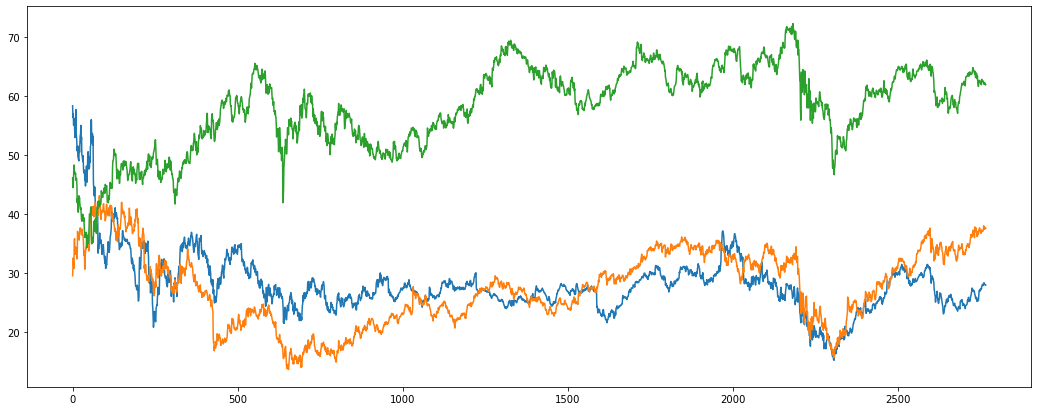

In [19]:
plt.figure(figsize=(18,7))
plt.plot(msft_train.close)
plt.plot(dis_train.close)
plt.plot(jnj_train.close)
plt.show()

In [23]:
msft_env = SGA_Env(msft_train, reward_on_close=True)
dis_env = SGA_Env(dis_train, reward_on_close=True)
jnj_env = SGA_Env(jnj_train, reward_on_close=True)

msft_valid_env = SGA_Env(msft_valid, random_ofs_on_reset=False, noise_on=False)
dis_valid_env = SGA_Env(dis_valid, random_ofs_on_reset=False, noise_on=False)
jnj_valid_env = SGA_Env(jnj_valid, random_ofs_on_reset=False, noise_on=False)

msft_test_env = SGA_Env(msft_test, random_ofs_on_reset=False, noise_on=False)
dis_test_env = SGA_Env(dis_test, random_ofs_on_reset=False, noise_on=False)
jnj_test_env = SGA_Env(jnj_test, random_ofs_on_reset=False, noise_on=False)

In [7]:
input_shape = [20, 63]
n_outputs = 2

In [4]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, 3, strides=strides,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv1D(filters, 3, strides=1,
                               padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, 1, strides=strides,
                                   padding='same', use_bias=False),
                keras.layers.BatchNormalization()]
            
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [3]:
class NoisyDense(keras.layers.Layer):
    def __init__(self, units, scale, activation='elu', kernel_initializer='he_uniform', noise_on=True, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.scale = scale
        self.activation = keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer
        self.noise_on = noise_on

    def build(self, input_shape):
        self.mu_w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer=self.kernel_initializer,
                               trainable=True)
        self.mu_b = self.add_weight(shape=(self.units,),
                               initializer=self.kernel_initializer,
                               trainable=True)
        self.sigma_w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer=self.kernel_initializer,
                               trainable=True)
        self.sigma_b = self.add_weight(shape=(self.units,),
                               initializer=self.kernel_initializer,
                               trainable=True)

    def call(self, inputs):
        if self.noise_on:
            e_w = np.random.normal(loc=0, scale=self.scale, size=self.units)
            noise_w = tf.multiply(self.sigma_w, e_w)
            w = noise_w + self.mu_w

            e_b = np.random.normal(loc=0, scale=self.scale, size=(self.units,))
            noise_b = tf.multiply(self.sigma_b, e_b)
            b = noise_b + self.mu_b
        elif not self.noise_on:
            w = self.mu_w
            b = self.mu_b
        
        return self.activation(tf.matmul(inputs, w) + b)

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [8]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
hidden1 = keras.layers.Conv1D(64, 7, strides=2, input_shape=[20,63],
                             padding='same', use_bias=False, kernel_regularizer=keras.regularizers.L2(l2=1e-8))(input_states)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = keras.layers.Activation('relu')(hidden2)
hidden4 = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(hidden3)
resunit1 = ResidualUnit(64, strides=1)(hidden4)
resunit2 = ResidualUnit(64, strides=1)(resunit1)
resunit3 = ResidualUnit(64, strides=1)(resunit2)
resunit4 = ResidualUnit(128, strides=2)(resunit3)
resunit5 = ResidualUnit(128, strides=1)(resunit4)
resunit6 = ResidualUnit(128, strides=1)(resunit5)
resunit7 = ResidualUnit(128, strides=1)(resunit6)
resunit8 = ResidualUnit(256, strides=2)(resunit7)
resunit9 = ResidualUnit(256, strides=1)(resunit8)
resunit10 = ResidualUnit(256, strides=1)(resunit9)
resunit11 = ResidualUnit(256, strides=1)(resunit10)
resunit12 = ResidualUnit(256, strides=1)(resunit11)
resunit13 = ResidualUnit(256, strides=1)(resunit12)
resunit14 = ResidualUnit(512, strides=2)(resunit13)
resunit15 = ResidualUnit(512, strides=1)(resunit14)
resunit16 = ResidualUnit(512, strides=1)(resunit15)
hidden5 = keras.layers.GlobalAvgPool1D()(resunit16)
flat = keras.layers.Flatten()(hidden5)
dense_value = NoisyDense(256, scale=0.1)(flat)
dense_adv = NoisyDense(256, scale=0.1)(flat)
#dense_value = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
#dense_adv = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
state_values = keras.layers.Dense(1)(dense_value)
raw_advantages = keras.layers.Dense(n_outputs)(dense_adv)
advantages = raw_advantages - K.mean(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

In [29]:
def save_model(path, name, model=model):
    now_weights = model.get_weights()
    now_weights_series = pd.Series(now_weights)
    with pd.HDFStore(path) as store:
        store.put(name, now_weights_series)

In [30]:
def load_model(path, name, model=model):
    with pd.HDFStore(path) as store:
        weights = store[name]
    list_weights = weights.to_list()
    model.set_weights(list_weights)

In [34]:
load_model('sga_weights.h5', 'sga/msft/noisydense/noisydata/diffsharperatio_n0.1/90episodes', valid_model)

In [32]:
target = keras.models.Model(inputs=[input_states], outputs=[Q_values])
target.set_weights(model.get_weights())

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 63)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 64)       28224       ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 64)      256         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 10, 64)       0           ['batch_normalization[0][0]']

In [33]:
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
hidden1 = keras.layers.Conv1D(64, 7, strides=2, input_shape=[20,63],
                             padding='same', use_bias=False)(input_states)
hidden2 = keras.layers.BatchNormalization()(hidden1)
hidden3 = keras.layers.Activation('relu')(hidden2)
hidden4 = keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')(hidden3)
resunit1 = ResidualUnit(64, strides=1)(hidden4)
resunit2 = ResidualUnit(64, strides=1)(resunit1)
resunit3 = ResidualUnit(64, strides=1)(resunit2)
resunit4 = ResidualUnit(128, strides=2)(resunit3)
resunit5 = ResidualUnit(128, strides=1)(resunit4)
resunit6 = ResidualUnit(128, strides=1)(resunit5)
resunit7 = ResidualUnit(128, strides=1)(resunit6)
resunit8 = ResidualUnit(256, strides=2)(resunit7)
resunit9 = ResidualUnit(256, strides=1)(resunit8)
resunit10 = ResidualUnit(256, strides=1)(resunit9)
resunit11 = ResidualUnit(256, strides=1)(resunit10)
resunit12 = ResidualUnit(256, strides=1)(resunit11)
resunit13 = ResidualUnit(256, strides=1)(resunit12)
resunit14 = ResidualUnit(512, strides=2)(resunit13)
resunit15 = ResidualUnit(512, strides=1)(resunit14)
resunit16 = ResidualUnit(512, strides=1)(resunit15)
hidden5 = keras.layers.GlobalAvgPool1D()(resunit16)
flat = keras.layers.Flatten()(hidden5)
dense_value = NoisyDense(256, scale=0.1, noise_on=False)(flat)
dense_adv = NoisyDense(256, scale=0.1, noise_on=False)(flat)
#dense_value = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
#dense_adv = keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform')(flat)
state_values = keras.layers.Dense(1)(dense_value)
raw_advantages = keras.layers.Dense(n_outputs)(dense_adv)
advantages = raw_advantages - K.mean(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
valid_model = keras.models.Model(inputs=[input_states], outputs=[Q_values])
valid_model.set_weights(model.get_weights())

In [18]:
'''class PrioritizedReplayBuffer():
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)
        self.priorities = deque(maxlen=maxlen)
        
    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def update_beta(self, episode):
        v = BETA_START + episode * (1.0 - BETA_START) / BETA_EPISODES
        self.beta = min(1, v)
        return self.beta
    
    def get_importance(self, probabilities):
        importance = ((1/len(self.buffer)) * (1/probabilities)) ** self.beta
        importance_normalized = importance / max(importance)
        return importance_normalized
    
    def sample(self, batch_size, priority_scale=1.0):
        sample_size = min(len(self.buffer), batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k=sample_size, weights=sample_probs)
        #samples = np.array(self.buffer)[sample_indices]
        batch = [self.buffer[index] for index in sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        
        states, actions, rewards, n_states, dones, rewards2, n2_states, dones2 = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(8)]
        return states, actions, rewards, n_states, dones, rewards2, n2_states, dones2, importance, sample_indices
    
    def set_priorities(self, indices, errors, offset=0.1):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset'''

In [35]:
#replay_buffer = PrioritizedReplayBuffer(50000)
replay_buffer = []
'''with pd.HDFStore('sga_buffer.h5') as store:
    replay_series = store['sga/msft/noisydata/log/354episodes']
replay_buffer = replay_series.to_list()'''

"with pd.HDFStore('sga_buffer.h5') as store:\n    replay_series = store['sga/msft/noisydata/log/354episodes']\nreplay_buffer = replay_series.to_list()"

In [36]:
def epsilon_greedy_policy(model, state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(2)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [37]:
def sample_experiences(batch_size=50):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, n_states, dones, rewards2, n2_states, dones2 = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(8)]
    return states, actions, rewards, n_states, dones, rewards2, n2_states, dones2

In [38]:
def play_two_steps(env, state, action, epsilon=0, add_to_buffer=True, model=model):
    if action is np.nan:
        action = epsilon_greedy_policy(model, state, epsilon)
    pass_on1 = True
    n_state, reward, done, info, return_ = env.step(action, pass_on1)

    action2 = epsilon_greedy_policy(model, n_state, epsilon)
    pass_on2 = False
    n2_state, reward2, done2, info2, _ = env.step(action2, pass_on2)
    
    if add_to_buffer:
        replay_buffer.append((state, action, reward, n_state, done, reward2, n2_state, done2))
    return n_state, reward, done, info, info2, action2, return_

In [39]:
batch_size = 48
discount_factor = 0.99
loss_fn = keras.losses.mean_squared_error

In [40]:
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, n_states, dones, rewards2, n2_states, dones2 = experiences
    next_Q_values = model.predict(n_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(n_states) * next_mask).sum(axis=1)

    next2_Q_values = model.predict(n2_states)
    best_next2_actions = np.argmax(next2_Q_values, axis=1)
    next2_mask = tf.one_hot(best_next2_actions, n_outputs).numpy()
    next2_best_Q_values = (target.predict(n2_states) * next2_mask).sum(axis=1)
    target_Q_values = (rewards + (1-dones) * discount_factor * rewards2 + 
                      (1-dones2) * (discount_factor ** 2) * next2_best_Q_values )
    
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    return loss

In [41]:
def valid_run(env):

    reward_list = []
    reward_mean = 0
    done = False
    action = np.nan
    next_action = np.nan
    losses = 0
    num_steps = 0
    eps = 0
    state = env.reset()
    print('-------------------------------------------------------------')

    while not done:
        state, reward, done, info, info2, next_action, return_ = play_two_steps(env, state, action, eps, model=valid_model)

        reward_list.append(reward)

        reward_mean += reward
        action = next_action
        num_steps += 1

    reward_mean = reward_mean/num_steps
    return reward_mean

In [42]:
start = 5
iterations = 128 #used to be 64
update_steps = 10
episodes = 625
episode_chunks = 5
valid_run_steps = 1

In [37]:
#with pd.HDFStore('sga_progress.h5') as store:
#    reward_series = store['sga/msft/reward/training250']
#    vreward_series = store['sga/msft/valid_reward/training250']

In [43]:
#reward_list = reward_series.to_list()
#vreward_list = vreward_series.to_list()
reward_list = []
msft_vreward_list = []
dis_vreward_list = []
jnj_vreward_list = []
loss_list = []
msft_best_reward = -np.inf
dis_best_reward = -np.inf
jnj_best_reward = -np.inf
durations = []
msft_best_weights = None
dis_best_weights = None
jnj_best_weights = None

In [44]:
def one_cycle(i, max_length, start, max_):
    midway = 0.4*max_length
    almost = 0.8*max_length
    if i <= midway:
        lr = (((4.5e-7)/250)*i + 5e-8)
    elif (i > midway) & (i <= almost):
        lr = (((4.5e-7)/250)*(-i) - 5e-8 + 1e-6)
    elif (i > almost) & (i <= max_length):
        lr = ((-3.96e-10)*i) + 2.48e-7
 
    return lr

In [45]:
def exp_lr(episode, start_lr, end_lr, episodes):
    num = start_lr/end_lr
    num2 = np.log(num) / episodes
    return (start_lr * np.exp((-episode)*num2))

In [1]:
for episode in range(1, 91):
    begin = time.time()
    
    env = jnj_env
    env_type = 'JNJ'
        
    reward_mean = 0
    done = False
    action = np.nan
    next_action = np.nan
    losses = 0
    num_steps = 0
    state = env.reset()
    print('-------------------------------------------------------------')
    #optimizer = keras.optimizers.Adam(one_cycle(episode, episodes))
    optimizer = keras.optimizers.Adam(exp_lr(episode, 1e-5, 5e-8, episodes))
    
    while not done:
        if episode < 0:
            eps = 1
        else:
            eps = 0
        
        state, reward, done, info, info2, next_action, return_ = play_two_steps(env, state, action, eps)
        
        reward_mean += reward
        action = next_action
        num_steps += 1
        
    reward_mean = reward_mean/num_steps
    reward_list.append(reward_mean)
    
    if episode > 85:
        if (len(reward_list) - np.argmax(reward_list) - 1) > 50:
            break
            
    if len(replay_buffer) > 60000:
        for i in range(4000):
            replay_buffer.pop(0)
        
    if episode >= 0:
        for i in range(iterations):
            loss = training_step(batch_size)
            losses += loss
            loss_list.append(loss)
            
        if episode % update_steps == 0:
            target.set_weights(model.get_weights())
            
        if episode % valid_run_steps == 0:
            valid_model.set_weights(model.get_weights())
            
            jnj_vreward_mean = valid_run(jnj_valid_env)
            jnj_vreward_list.append(jnj_vreward_mean)
            
            if jnj_vreward_mean > jnj_best_reward:
                jnj_best_weights = valid_model.get_weights()
                jnj_best_reward = jnj_vreward_mean
    
    stop = time.time()
    duration = stop-begin
    durations.append(duration)
    print('Training:')
    print('Episode: {}, Steps: {}, Reward_mean: {}, Stock: {}'.format(episode, num_steps, round(reward_mean, 3), env_type))
    print('Learning_rate: {}, Loss: {}'.format(round(exp_lr(episode, 5e-5, 5e-8, episodes),7), losses))
    if (episode % valid_run_steps == 0) & (episode >= 0):
        print('')
        print('Validation:')
        print('JNJ Reward_mean: {}'.format(round(jnj_vreward_mean,3)))
    print('Duration: {}'.format(round(duration,2)))

NameError: name 'time' is not defined

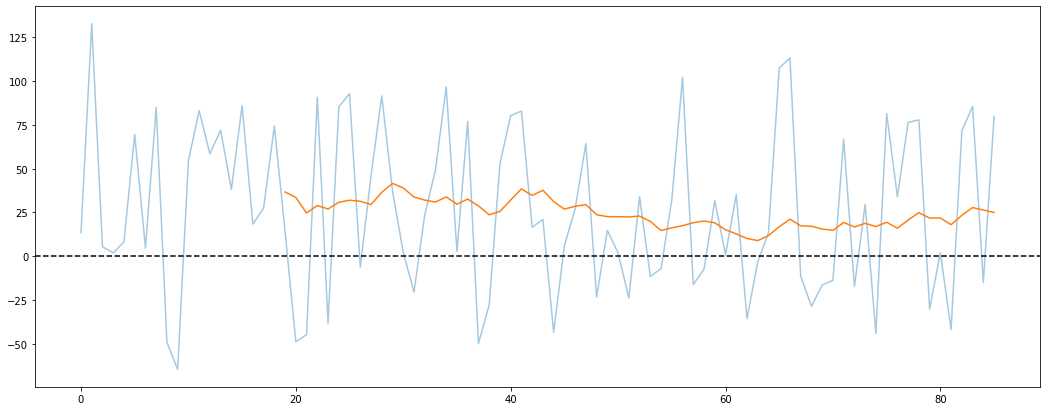

In [42]:
plt.figure(figsize=(18,7))
plt.plot(reward_list, alpha=0.4)
reward_list = pd.Series(reward_list)
plt.plot(reward_list.rolling(20).mean())
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

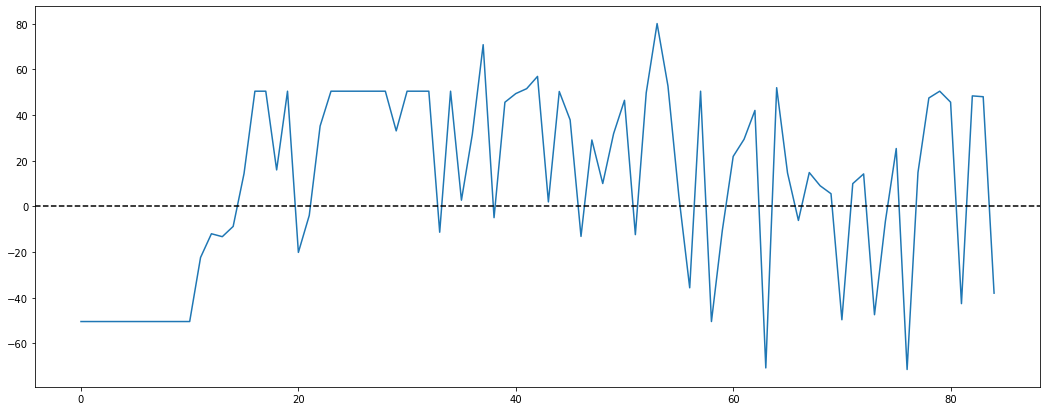

In [44]:
plt.figure(figsize=(18,7))
plt.plot(jnj_vreward_list)
#plt.plot(dis_vreward_list)
#plt.plot(jnj_vreward_list)
plt.axhline(y = 0, color = 'black', linestyle = '--')
#plt.axvline(x=223, color='black', linestyle = '--')
plt.show()

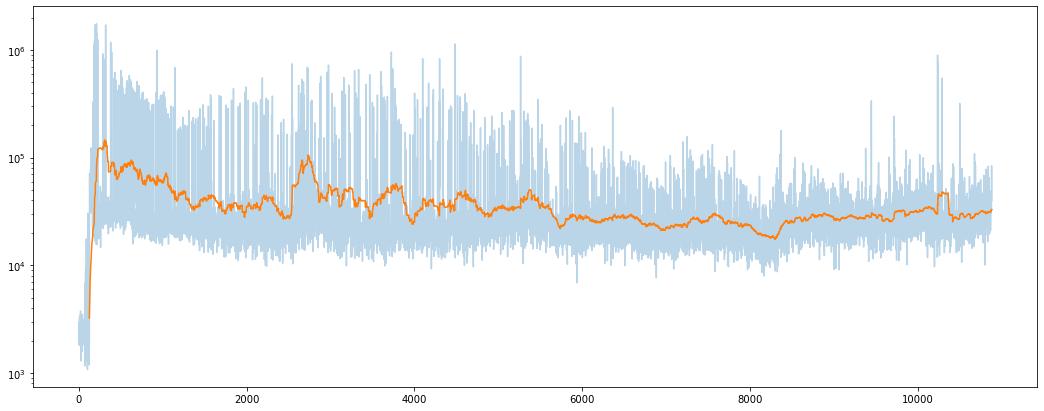

In [45]:
plt.figure(figsize=(18,7))
plt.plot(loss_list, alpha=0.3)
loss_series = pd.Series(loss_list)
plt.plot(loss_series.rolling(128).mean())
plt.yscale('log')
#plt.ylim(1,1e5)
plt.show()

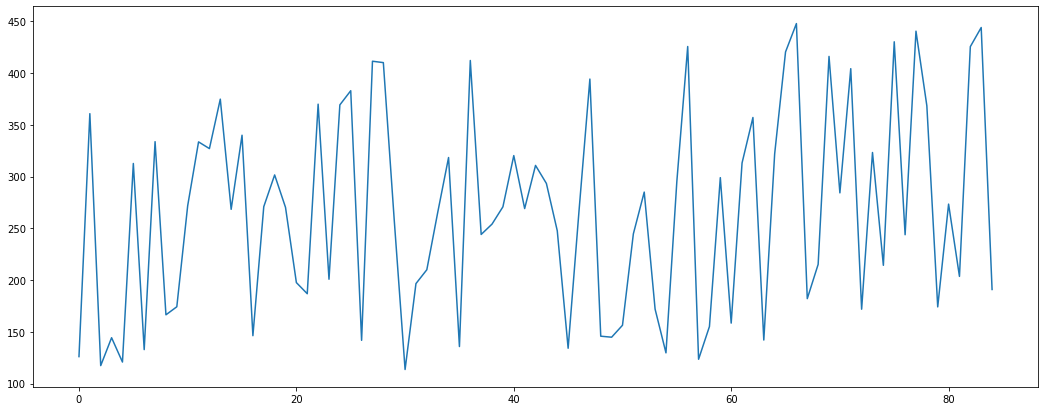

In [46]:
plt.figure(figsize=(18,7))
plt.plot(durations)
plt.show()

In [52]:
#reward_series = pd.Series(reward_list)
#vreward_series = pd.Series(vreward_list)

In [73]:
with pd.HDFStore('sga_progress.h5') as store:
    store.put('sga/msft/reward/training250', reward_list)
    store.put('sga/msft/valid_reward/training250', vreward_list)

In [74]:
save_model('sga_weights.h5', 'sga/dis/noisydense/noisydata/diffsharperatio/250episodes')

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '250episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_14016\1565519893.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [47]:
valid_model.set_weights(jnj_best_weights)

In [89]:
msft_two = msft_train.append(msft_valid, ignore_index=True)
dis_two = dis_train.append(dis_valid, ignore_index=True)
jnj_two = jnj_train.append(jnj_valid, ignore_index=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\212759569.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msft_two = msft_train.append(msft_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\212759569.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis_two = dis_train.append(dis_valid, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\212759569.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jnj_two = jnj_train.append(jnj_valid, ignore_index=True)


In [90]:
msft = msft_two.append(msft_test, ignore_index=True)
dis = dis_two.append(dis_test, ignore_index=True)
jnj = jnj_two.append(jnj_test, ignore_index=True)

C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\4208557694.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  msft = msft_two.append(msft_test, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\4208557694.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dis = dis_two.append(dis_test, ignore_index=True)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\4208557694.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  jnj = jnj_two.append(jnj_test, ignore_index=True)


<AxesSubplot:>

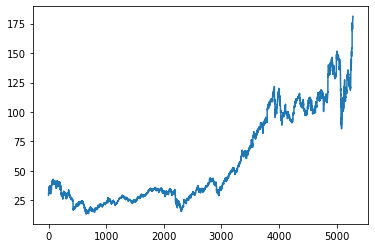

In [91]:
dis.close.plot()

In [92]:
#full_run_env = SGA_Env(jnj, random_ofs_on_reset=False, noise_on=False)
msft_test_env = SGA_Env(msft, random_ofs_on_reset=False, noise_on=False)
dis_test_env = SGA_Env(dis, random_ofs_on_reset=False, noise_on=False)
jnj_test_env = SGA_Env(jnj, random_ofs_on_reset=False, noise_on=False)

In [93]:
full_reward_list = []
full_return_list = []
actions = []
begin = time.time()
reward_sofar = 1
reward_mean = 0
done = False
action = np.nan
next_action = np.nan
losses = 0
num_steps = 0
eps = 0
state = dis_test_env.reset()
print('-------------------------------------------------------------')
    
while not done:
    state, reward, done, info, info2, next_action, return_ = play_two_steps(dis_test_env, state, action, eps, add_to_buffer=False, model=valid_model)
    
    full_reward_list.append(reward)
    full_return_list.append(return_)
    
    if return_ != 0:
        reward_sofar *= return_
        
    reward_mean += reward
    action = next_action
    actions.append(action)
    num_steps += 1
        
arr = (reward_sofar ** (1/(num_steps/252)))
reward_mean = reward_mean/num_steps
end = time.time()
total_time = end-begin

-------------------------------------------------------------
1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 38ms/step


In [101]:
arr

1.0

In [102]:
#msft
reward_mean

283.3915287805327

In [94]:
#dis
reward_mean

99.77362875445502

In [78]:
#jnj
reward_mean

-58.13796309648843

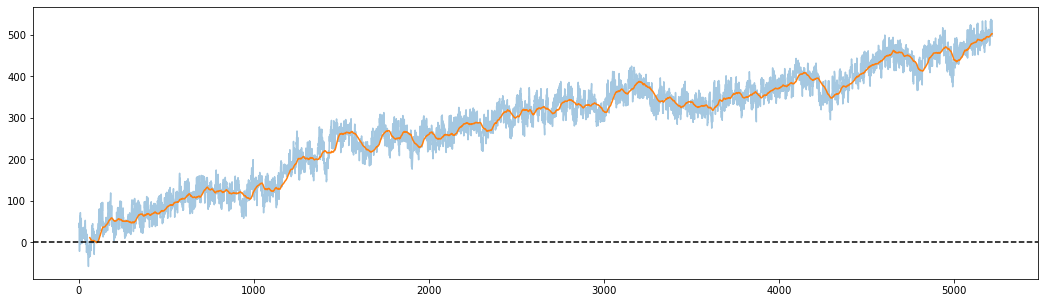

In [103]:
#msft best weights on msft
plt.figure(figsize=(18,5))
plt.plot(full_reward_list, alpha=0.4)
full_reward_series = pd.Series(full_reward_list)
plt.plot(full_reward_series.rolling(63).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

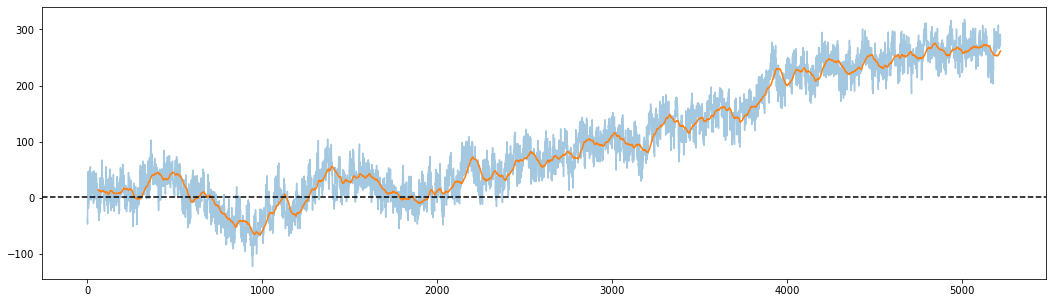

In [95]:
#dis
plt.figure(figsize=(18,5))
plt.plot(full_reward_list, alpha=0.4)
full_reward_series = pd.Series(full_reward_list)
plt.plot(full_reward_series.rolling(63).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

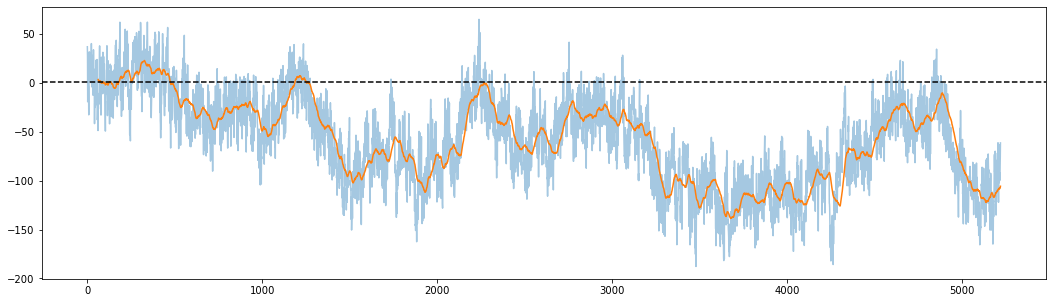

In [79]:
#jnj
plt.figure(figsize=(18,5))
plt.plot(full_reward_list, alpha=0.4)
full_reward_series = pd.Series(full_reward_list)
plt.plot(full_reward_series.rolling(63).mean())
plt.axhline(y = 1, color = 'black', linestyle = '--')
plt.show()

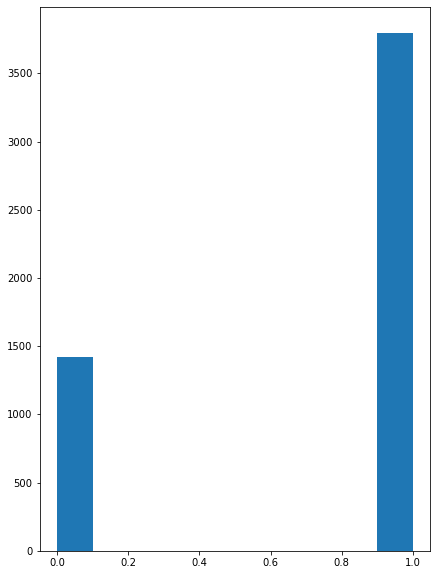

In [104]:
#msft best weights on msft
fig, ax = plt.subplots(figsize =(7, 10))
ax.hist(actions)
 
# Show plot
plt.show()

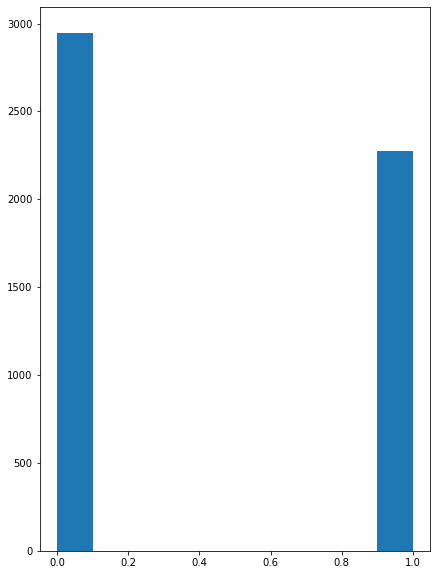

In [96]:
#dis
fig, ax = plt.subplots(figsize =(7, 10))
ax.hist(actions)
 
# Show plot
plt.show()

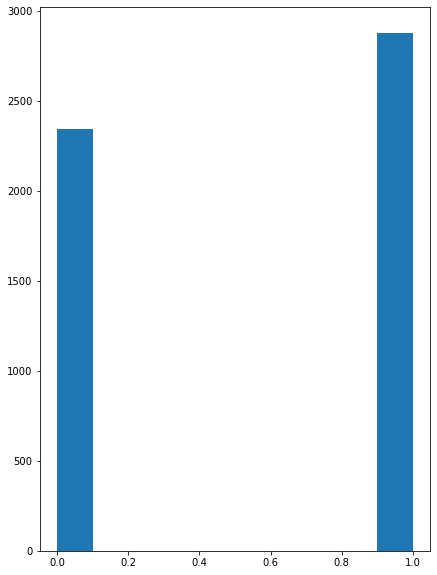

In [80]:
#jnj
fig, ax = plt.subplots(figsize =(7, 10))
ax.hist(actions)
 
# Show plot
plt.show()

In [97]:
actions[-10:]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [98]:
len(actions)

5219

In [101]:
actions.append(0)

In [99]:
dis.shape

(5284, 23)

In [56]:
def point_type_listmaker(prices, actions):
    length = len(prices.close)
    train = prices.loc[63:]
    train.reset_index(inplace=True, drop=True)
    #print(type(prices))
    #print(type(train))
    #print(type(actions))
    train['action'] = actions
    buy_rows = train.loc[train['action'] == 0]
    short_rows = train.loc[train['action'] == 1]

    return buy_rows, short_rows

In [57]:
def eam_plotter(prices, stock, actions):
    length = len(prices.close)
    plt.plot(prices.date.loc[63:], prices.close.loc[63:], color='black', label='Normalized ' + stock + ' Price')
    
    longs, shorts = point_type_listmaker(prices, actions)
    
    plt.scatter(longs.date, longs.close, color='green', marker='o', label='Signal-Long', alpha=0.3)
    plt.scatter(shorts.date, shorts.close, color='red', marker='o', label='Signal-Short', alpha=0.3)
    #plt.scatter(closes.date, closes.close, color='red', marker='s', label='Position Closed(Closing)', alpha=0.3)
    #plt.scatter(opens.date, opens.close, color='blue', marker=(5, 1), label='Position Opened(Buying)', alpha=0.2)
    #plt.axvline(xdata=closes.date)
    #plt.axvline(xdata=opens.date)
    
    plt.axis('tight')
    plt.xlabel('Date')
    plt.ylabel('Normalized Stock Price')
    plt.legend()

C:\Users\isaac\AppData\Local\Temp\ipykernel_17052\3747847557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['action'] = actions


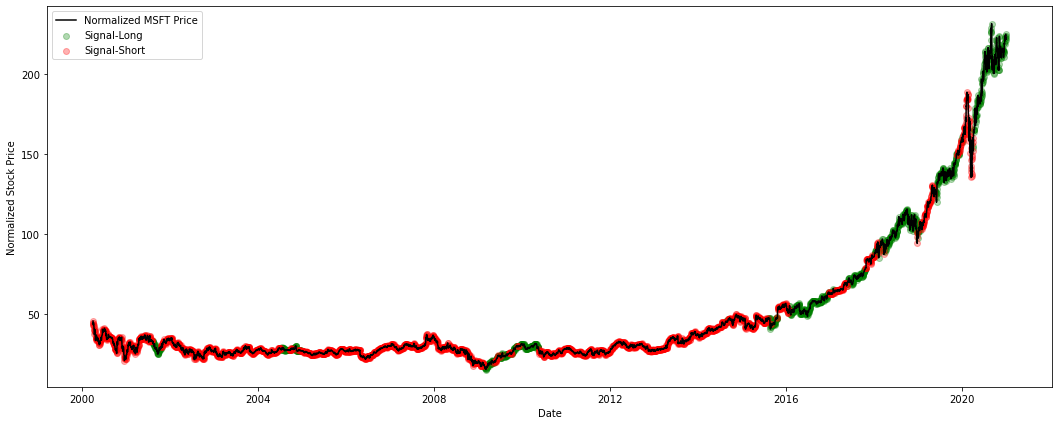

In [112]:
#msft best weights on msft
plt.figure(figsize=(18,7))
eam_plotter(msft, 'MSFT', actions)
plt.show()

C:\Users\isaac\AppData\Local\Temp\ipykernel_19300\3747847557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['action'] = actions


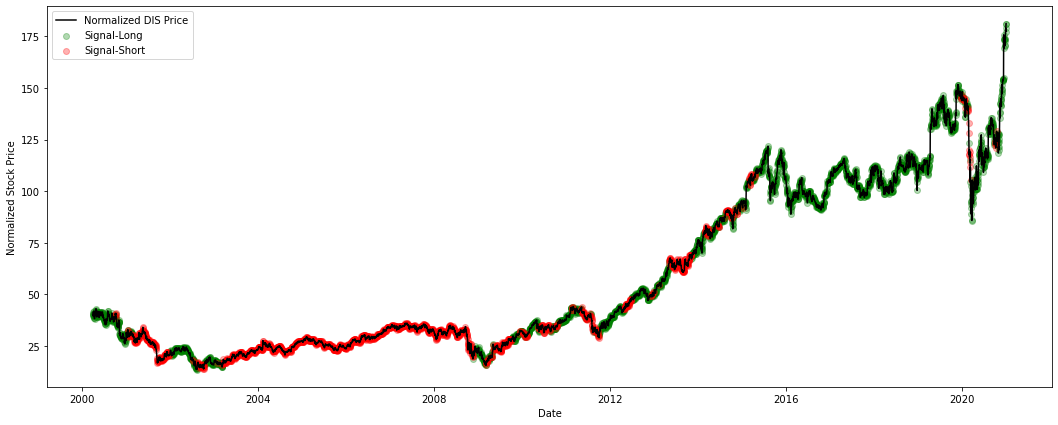

In [102]:
#dis
plt.figure(figsize=(18,7))
eam_plotter(dis, 'DIS', actions)
plt.show()

C:\Users\isaac\AppData\Local\Temp\ipykernel_596\3747847557.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['action'] = actions


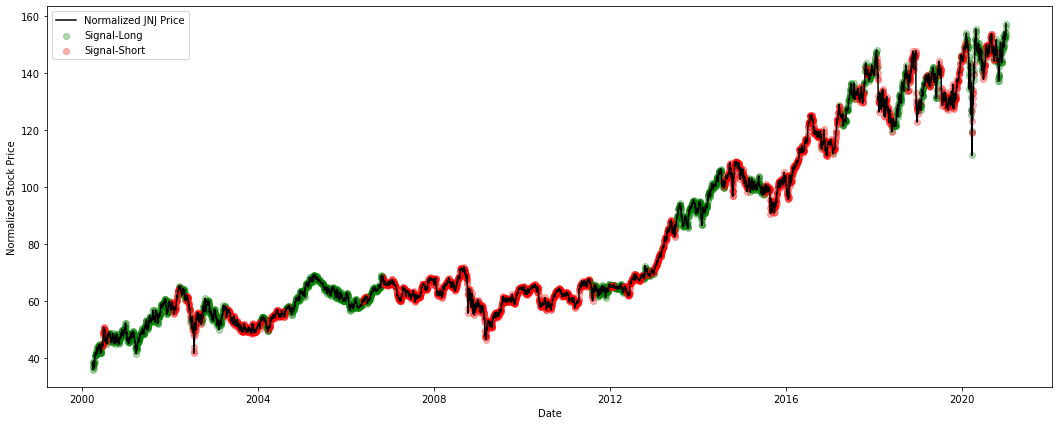

In [87]:
#jnj best weights on jnj
plt.figure(figsize=(18,7))
eam_plotter(jnj, 'JNJ', actions)
plt.show()

In [81]:
type(model.get_weights())

list

In [75]:
len(replay_buffer)

49665

In [76]:
series = pd.Series(replay_buffer)

In [77]:
with pd.HDFStore('sga_buffer.h5') as store:
    store.put('sga/dis/noisydata/log/250episodes', series)

C:\Users\isaac\AppData\Local\Temp\ipykernel_14016\3253804927.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put('sga/dis/noisydata/log/250episodes', series)


In [96]:
#this is the microsoft SGA
save_model('sga_weights.h5', 'sga/realmsft/noisydense/noisydata/diffsharperatio_n0.1/90episodes', valid_model)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'diffsharperatio_n0.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '90episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_17052\1565519893.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [126]:
#this is the disney SGA
#save_model('sga_weights.h5', 'sga/msft/noisydense/noisydata/diffsharperatio_n0.1/90episodes', valid_model)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '90episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_23384\1565519893.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [89]:
#this is the johnson and johnson SGA
save_model('sga_weights.h5', 'sga/jnj/noisydense/noisydata/diffsharperatio_n0.1/90episodes', valid_model)

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: 'diffsharperatio_n0.1'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '90episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_596\1565519893.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [67]:
save_model('sga_weights.h5', 'sga/msft/noisydense/noisydata/diffsharperatio/500episodes')

C:\ProgramData\Anaconda3\lib\site-packages\tables\path.py:155: NaturalNameWarning: object name is not a valid Python identifier: '500episodes'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\isaac\AppData\Local\Temp\ipykernel_19704\1565519893.py:5: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  store.put(name, now_weights_series)


In [103]:
action_series = pd.Series(actions)
with pd.HDFStore('sga_signals.h5') as store:
    store.put('sga/train_valid_test/dis', action_series)